# Train DECiSION incl. data augmentation

## Set seeds and import packages

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import DECiSION_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_training_history, plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report
from dltoolkit.iomisc import HDF5Generator_Segment

from thesis_common import convert_img_to_pred, convert_pred_to_img, create_hdf5_db,\
    show_image, read_images, read_groundtruths, print_training_info
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam, SGD, Adadelta
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Change how TensorFlow allocates GPU memory

In [2]:
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
 
# Only allow a percentage of the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified
k.tensorflow_backend.set_session(tf.Session(config=config))

## Convert individual images set to HDF5 data sets

In [3]:
def perform_hdf5_conversion(settings):
    """Convert the individual .jpg files (images and ground truths) to four .hdf5 files:
    - Two with the training set (train_imgs.h5 and train_masks.h5)
    - Two with the validation set (val_imgs.h5 and val_masks.h5)
    
    If TRN_TRAIN_VAL_SPLIT is set to zero the validation set data sets are NOT generated.
    """
    # Prepare the path to the training images and ground truths
    img_exts = ".jpg"
    img_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TRAINING_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])

    # Obtain a list of paths to the training images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Split the training set into a training and validation set. Consecutive slices no longer
    # belong to the same patient
    train_img, val_img, train_msk, val_msk = train_test_split(img_list, msk_list,
                                                              test_size=settings.TRN_TRAIN_VAL_SPLIT,
                                                              random_state=settings.RANDOM_STATE,
                                                              shuffle=True)
    
    # Create the HDF5 data sets
    output_paths = []

    # Training images
    output_paths.append(create_hdf5_db(train_img, "train", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Training ground truths
    output_paths.append(create_hdf5_db(train_msk, "train", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    # Validation images
    output_paths.append(create_hdf5_db(val_img, "val", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Validation ground truths
    output_paths.append(create_hdf5_db(val_msk, "val", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))

    return output_paths

## Enable/disable cross-validation

In [4]:
USE_KFOLD_CV = False

In [5]:
# Convert image files to HDF5
if settings.IS_DEVELOPMENT:
    print("\n--- Converting images to HDF5, full paths:\n")
    hdf5_paths = perform_hdf5_conversion(settings)
    
    if settings.TRN_TRAIN_VAL_SPLIT == 0:
        print("\nValidation set NOT created.")
    else:
        print("\nCreated a {} training/validation set".format(settings.TRN_TRAIN_VAL_SPLIT))
else:
    # During development avoid performing HDF5 conversion for every run
    hdf5_paths = ["../data/MSC8002/training/train_images.h5",
                  "../data/MSC8002/training/train_groundtruths.h5",
                  "../data/MSC8002/training/val_images.h5",
                  "../data/MSC8002/training/val_groundtruths.h5"
                  ]

Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00
Creating HDF5 database 100% |###################################| Time: 0:00:00



--- Converting images to HDF5, full paths:

../data/MSC8002/training/train_images.h5
../data/MSC8002/training/train_groundtruths.h5
../data/MSC8002/training/val_images.h5
../data/MSC8002/training/val_groundtruths.h5

Created a 0.1 training/validation set


## Set the class distribution

In [6]:
class_weights = [settings.CLASS_WEIGHT_BACKGROUND, settings.CLASS_WEIGHT_BLOODVESSEL]
print("Class distribution: {}".format(class_weights))

Class distribution: [1.0, 8.0]


## Create the U-Net model

In [7]:
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES,
               dropout_rate=settings.TRN_DROPOUT_RATE)
# model = unet.build_model_BRAIN_3layer(use_bn=True, use_dropout=False)
model = unet.build_model_BRAIN_4layer(use_bn=True, use_dropout=False)

## Create paths

In [8]:
# Prepare some path strings
model_path = os.path.join(settings.MODEL_PATH, "DECiSION_" + unet.title + "_ep{}.model".format(settings.TRN_NUM_EPOCH))
summ_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_model_summary.txt")
csv_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title + "_training_ep{}_bs{}.csv".format(settings.TRN_NUM_EPOCH,
                                                                                            settings.TRN_BATCH_SIZE))

## Save/print model architecture information

In [9]:
model.summary()
model_summary_to_file(model, summ_path)
model_architecture_to_file(unet.model, settings.OUTPUT_PATH + "DECiSION_" + unet.title)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

## Compile the model

In [10]:
# Set the optimiser, loss function and metrics
opt = Adam()
# opt = Adadelta()
metrics = [dice_coef]
loss = weighted_pixelwise_crossentropy_loss(class_weights)

# Compile
model.compile(optimizer=opt, loss=loss, metrics=metrics)

## Load data

### Option 1: Use generators

### Option 2: Load all data into memory

In [11]:
train_imgs = read_images(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_groundtruths(hdf5_paths[1], settings.HDF5_KEY)
train_grndtr_ext_conv = convert_img_to_pred(train_grndtr, settings.NUM_CLASSES, settings.VERBOSE)  # softmax: 4D
print("Number of training samples: {}\n".format(len(train_imgs)))

# Read the validation set (only when NOT using cross-validation)
if not USE_KFOLD_CV:
    val_imgs = read_images(hdf5_paths[2], settings.HDF5_KEY)
    val_grndtr = read_groundtruths(hdf5_paths[3], settings.HDF5_KEY)
    val_grndtr_ext_conv = convert_img_to_pred(val_grndtr, settings.NUM_CLASSES, settings.VERBOSE)  # softmax: 4D
    print("Number of validation samples: {}\n".format(len(val_imgs)))
else:
    print("Using cross validation, not loading a validation set")

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8
Elapsed time: 0.027070999145507812
Number of training samples: 27

Loading image HDF5: ../data/MSC8002/training/val_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training/val_groundtruths.h5 with dtype = uint8
Elapsed time: 0.0022296905517578125
Number of validation samples: 3



## Train the model

### Train WITH a validation set - GENERATOR

### Train WITHOUT a validation set - GENERATOR

### Train WITH a validation set - ALL IN MEMORY

In [12]:
if not USE_KFOLD_CV:
    print("Training with a training/validation split, all in memory.")
    print_training_info(unet, model_path, train_imgs.shape, settings, class_weights, opt, loss)
    print("Training start:\n")

    # Prepare callbacks
    callbacks = [
        ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', min_delta=0, patience=settings.TRN_EARLY_PATIENCE, verbose=0, mode="auto"),
        CSVLogger(csv_path, append=False),
        ]

    # Fit the model using a training set only
    start_time = time.time()
    hist = model.fit(train_imgs, train_grndtr_ext_conv,
                     epochs=settings.TRN_NUM_EPOCH,
                     batch_size=settings.TRN_BATCH_SIZE,
                     verbose=1,
                     shuffle=True,
                     validation_data=(val_imgs, val_grndtr_ext_conv),
                     callbacks=callbacks)

    print("\n\nElapsed training time: {} min".format(int((time.time() - start_time))/60))
else:
    print("Cross-validation selected, not performing one-off training with a validation set")

Training with a training/validation split, all in memory.

Generic information:
              Model: UNet_brain_4layer_BN
          Saving to: ../savedmodels/DECiSION_UNet_brain_4layer_BN_ep100.model
        Input shape: (27, 240, 240, 1)

Hyper parameters:
          Optimizer: <class 'keras.optimizers.Adam'>
                   : 0 = ('lr', 0.0010000000474974513)
                   : 1 = ('beta_1', 0.8999999761581421)
                   : 2 = ('beta_2', 0.9990000128746033)
                   : 3 = ('decay', 0.0)
                   : 4 = ('epsilon', 1e-07)
                   : 5 = ('amsgrad', False)
               Loss: <function weighted_pixelwise_crossentropy_loss.<locals>.loss at 0x1a1f1aa950>
         IMG_HEIGHT: 240
          IMG_WIDTH: 240
       IMG_CHANNELS: 1
        NUM_CLASSES: 2
        SLICE_START: 59
          SLICE_END: 69
    IMG_CROP_HEIGHT: 40
     IMG_CROP_WIDTH: 40
     TRN_BATCH_SIZE: 1
  TRN_LEARNING_RATE: 0.001
      TRN_NUM_EPOCH: 100
TRN_TRAIN_VAL_SPLIT: 0.1
   

### Train WITHOUT a validation set - ALL IN MEMORY

## Use k-Fold Cross Validation

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

https://github.com/keras-team/keras/issues/4530

https://stackoverflow.com/questions/40854232/keras-scikit-learn-using-fit-generator-with-cross-validation/40866543#40866543

https://stackoverflow.com/questions/41214527/k-fold-cross-validation-using-keras

https://www.kaggle.com/stefanie04736/simple-keras-model-with-k-fold-cross-validation

NICE: https://www.kaggle.com/zfturbo/fishy-keras-lb-1-25267/code

In [13]:
if USE_KFOLD_CV:
    from sklearn.model_selection import KFold

    print("Training using cross validation")
    print_training_info(unet, model_path, train_imgs.shape, settings, class_weights, opt, loss)
    print("Training start:\n")

    # Set the optimiser, loss function and metrics
    opt = Adam()
    metrics = [dice_coef]
    loss = weighted_pixelwise_crossentropy_loss(class_weights)

    # Create the folds
    kfold = KFold(n_splits=settings.TRN_NUM_KFOLD_SPLITS, shuffle=True, random_state=settings.RANDOM_STATE)
    cvscores = []
    cvlosses = []
    fold_id = 1
    for train_idx, test_idx in kfold.split(train_imgs, train_grndtr_ext_conv):
        print("\n-----> Fold {} of {} <-----".format(fold_id, settings.TRN_NUM_KFOLD_SPLITS))
        print("Training: {} slices, test: {} slices".format(len(train_idx), len(test_idx)))
        
        # Create and compile the model before each fold (to reset the weights)
        model = unet.build_model_softmax()
        model.compile(optimizer=opt, loss=loss, metrics=metrics)

        # Include the number of the fold in the file name
        kfold_path = os.path.join(settings.MODEL_PATH, "DECiSION_" + unet.title + "_ep{}_kfold{}.model".format(settings.TRN_NUM_EPOCH, fold_id))

        callbacks = [
            ModelCheckpoint(kfold_path, monitor="loss", mode="min", save_best_only=True, verbose=1),
            EarlyStopping(monitor='loss', min_delta=0, patience=settings.TRN_EARLY_PATIENCE, verbose=0, mode="auto"),
            CSVLogger(csv_path, append=False),
        ]

        hist = model.fit(train_imgs[train_idx], train_grndtr_ext_conv[train_idx],
                         epochs=settings.TRN_NUM_EPOCH,
                         batch_size=settings.TRN_BATCH_SIZE,
                         verbose=2,
                         shuffle=True,
                         callbacks=callbacks)

        scores = model.evaluate(train_imgs[test_idx], train_grndtr_ext_conv[test_idx], verbose=2)
        print("\n-----> Fold {}: {}: {:.2f}%% - {}: {:.2f}\n".format(fold_id,
                                                          model.metrics_names[1],
                                                          scores[1]*100,
                                                          model.metrics_names[0],
                                                          scores[0]))
        cvscores.append(scores[1] * 100)
        cvlosses.append(scores[0])

        fold_id += 1

    print("Results")
    print("------------------")
    for i in range(NUM_SPLITS):
        print("Fold {}: {}: {:.2f}% - {}: {:.2f}\n".format(i,
                                                          model.metrics_names[1],
                                                          cvscores[i],
                                                          model.metrics_names[0],
                                                          cvlosses[i]))
    print("------------------")

    print("\nEstimated test performance: mean and std dev")
    print("------------------")
    print("\n{}: {:.2f} (+/- {:.2f})".format(model.metrics_names[0], np.mean(cvlosses), np.std(cvlosses)))
    print("{}: {:.2f}% (+/- {:.2f}%)".format(model.metrics_names[1], np.mean(cvscores), np.std(cvscores)))

    print("\nFold Id with the highest DICE: {}".format(np.argmax(cvscores)+1))
    print(" Fold Id with the lowest loss: {}".format(np.argmin(cvscores)+1))
    
    print("\nFitting model using all training data")
    print("------------------")
    # Prepare callbacks
    callbacks = [
        ModelCheckpoint(model_path, monitor="loss", mode="min", save_best_only=True, verbose=1),
        EarlyStopping(monitor='loss', min_delta=0, patience=settings.TRN_EARLY_PATIENCE, verbose=0, mode="auto"),
        CSVLogger(csv_path, append=False),
        ]

    model = unet.build_model_softmax()
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    # Fit the model using a training set only
    start_time = time.time()
    hist = model.fit(train_imgs, train_grndtr_ext_conv,
#                      epochs=settings.TRN_NUM_EPOCH,
                     epochs=2,
                     batch_size=settings.TRN_BATCH_SIZE,
                     verbose=1,
                     shuffle=True,
                     callbacks=callbacks)

    print("\n\nElapsed training time: {} min".format(int((time.time() - start_time))/60))

## Plot the results

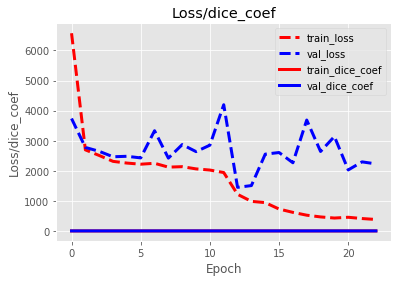

In [14]:
if not USE_KFOLD_CV:
    plot_training_history(hist,
                          settings.TRN_NUM_EPOCH,
                          show=True,
                          save_path=settings.OUTPUT_PATH + unet.title,
                          time_stamp=True,
                          metric="dice_coef")
else:
    print("Using cross-validation, no training history saved")

## Perform pipeline test

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8
Predictions shape: (27, 240, 240, 2)
Elapsed time: 0.13301587104797363


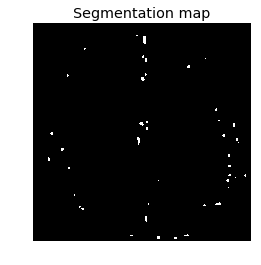

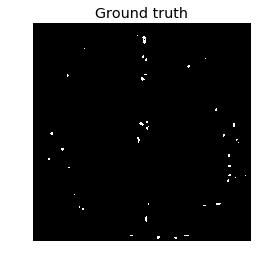

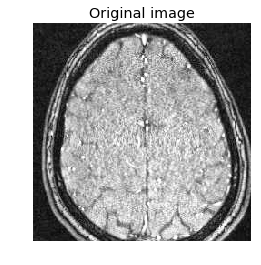

   seg map 255 dtype uint8
  gr truth 255 dtype uint8
  original 1.0 dtype float16


In [15]:
# Read training images and ground truths
train_imgs = read_images(hdf5_paths[0], settings.HDF5_KEY)
train_grndtr = read_groundtruths(hdf5_paths[1], settings.HDF5_KEY)

# Predict
predictions = model.predict(train_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)
print("Predictions shape: {}".format(predictions.shape))

# Convert predictions to images
predictions_imgs = convert_pred_to_img(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)

# Show a single image, ground truth and segmentation map
show_image(np.squeeze(predictions_imgs[0]), 'Segmentation map')
show_image(np.squeeze(train_grndtr[0]), 'Ground truth')
show_image(np.squeeze(train_imgs[0]), 'Original image')

print("   seg map {} dtype {}".format(np.max(predictions_imgs[0]), predictions_imgs[0].dtype))
print("  gr truth {} dtype {}".format(np.max(train_grndtr[0]), train_grndtr[0].dtype))
print("  original {} dtype {}".format(np.max(train_imgs[0]), train_imgs[0].dtype))